In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357284 sha256=03882380f390268b6d464eed00c5e31e3752336c990d7bfc65d3407f6ffbe017
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic, SVD, accuracy
from surprise.model_selection import KFold
from surprise import accuracy
import matplotlib.pyplot as plt
%matplotlib inline

Load Data

In [ ]:

# Load dataset
data = pd.read_csv('ratings_small.csv')
print(data.describe())
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)


              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09


Evaluate model with K Fold = 5

In [ ]:
def evaluate_model(algo, data):
    cv = KFold(n_splits=5)
    mae, rmse = [], []
    for train, test in cv.split(data):
        algo.fit(train)
        predictions = algo.test(test)
        mae.append(accuracy.mae(predictions, verbose=False))
        rmse.append(accuracy.rmse(predictions, verbose=False))

    return sum(mae) / len(mae), sum(rmse) / len(rmse)

In [ ]:
# PMF (Probabilistic Matrix Factorization) is equivalent to SVD when unbiased, or no baselines are used
pmf = SVD(biased = False)
mae_pmf, rmse_pmf = evaluate_model(pmf, data)

# User based Collaborative Filtering
user_cf = KNNBasic(sim_options={'user_based': True})
mae_user, rmse_user = evaluate_model(user_cf, data)

# Item based Collaborative Filtering
item_cf = KNNBasic(sim_options={'user_based': False})
mae_item, rmse_item = evaluate_model(item_cf, data)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
# MAE and RMSE for all three models
print(f"PMF - MAE: {mae_pmf}, RMSE: {rmse_pmf}")
print(f"User-CF - MAE: {mae_user}, RMSE: {rmse_user}")
print(f"Item-CF - MAE: {mae_item}, RMSE: {rmse_item}")


PMF - MAE: 0.778902388457485, RMSE: 1.0084846368011875
User-CF - MAE: 0.7441946221107354, RMSE: 0.9681520409939568
Item-CF - MAE: 0.720880053624169, RMSE: 0.9346884013792873


In [ ]:
# Similarities
similarities = ['cosine', 'msd', 'pearson']
results = {
    'User-Based': {'cosine': {}, 'msd': {}, 'pearson': {}},
    'Item-Based': {'cosine': {}, 'msd': {}, 'pearson': {}}
}


In [ ]:
def evaluate_similarity(sim_metric, user_based=True):
    sim_options = {
        'name': sim_metric,
        'user_based': user_based
    }

    algo = KNNBasic(sim_options=sim_options)

    kf = KFold(n_splits=5)
    mae_scores, rmse_scores = [], []

    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        mae_scores.append(accuracy.mae(predictions, verbose=False))
        rmse_scores.append(accuracy.rmse(predictions, verbose=False))

    avg_mae = sum(mae_scores) / len(mae_scores)
    avg_rmse = sum(rmse_scores) / len(rmse_scores)

    return avg_mae, avg_rmse

In [ ]:
for sim in similarities:
    # Evaluate sim over User-Based CF
    mae, rmse = evaluate_similarity(sim, user_based=True)
    results['User-Based'][sim]['MAE'] = mae
    results['User-Based'][sim]['RMSE'] = rmse

    # Evaluate sim over Item-Based CF
    mae, rmse = evaluate_similarity(sim, user_based=False)
    results['Item-Based'][sim]['MAE'] = mae
    results['Item-Based'][sim]['RMSE'] = rmse


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

In [ ]:
# Results
print("User-Based CF:")
print(pd.DataFrame(results['User-Based']))

print("\nItem-Based CF:")
print(pd.DataFrame(results['Item-Based']))

User-Based CF:
        cosine       msd   pearson
MAE   0.768210  0.744178  0.773709
RMSE  0.994664  0.968122  0.999766

Item-Based CF:
        cosine       msd   pearson
MAE   0.775153  0.721375  0.767995
RMSE  0.995686  0.935352  0.988966


In [ ]:
def plot_results(results, metric):
    x = ['cosine', 'msd', 'pearson']

    user_mae = [results['User-Based'][sim][metric] for sim in x]
    item_mae = [results['Item-Based'][sim][metric] for sim in x]

    plt.figure(figsize=(10, 5))

    plt.plot(x, user_mae, marker='o', label='User-Based', color='blue')
    plt.plot(x, item_mae, marker='x', label='Item-Based', color='green')

    plt.title(f'{metric} for User vs Item')
    plt.xlabel('Similarity Metric')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

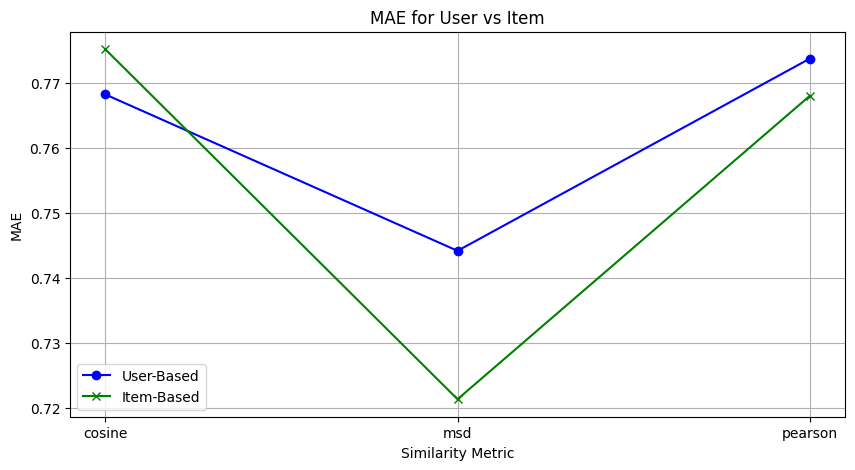

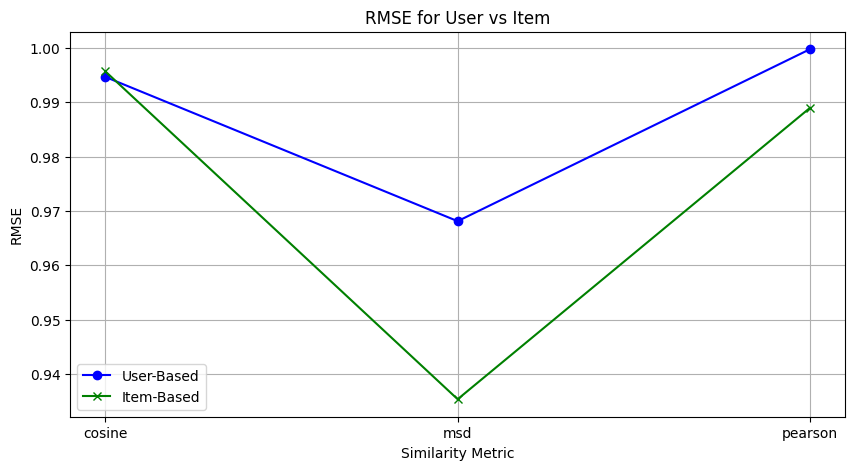

In [ ]:
# Plots for comparing User based vs Item based
plot_results(results, 'MAE')
plot_results(results, 'RMSE')


In [ ]:
def evaluate_k_neighbors(user_based, k_values=[5, 10, 20, 30, 40, 50]):
    results = {'K': [], 'MAE': [], 'RMSE': []}

    for k in k_values:
        algo = KNNBasic(k=k, sim_options={'user_based': user_based})

        # Use 5-fold cross-validation
        kf = KFold(n_splits=5)
        mae_scores, rmse_scores = [], []

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            mae_scores.append(accuracy.mae(predictions, verbose=False))
            rmse_scores.append(accuracy.rmse(predictions, verbose=False))

        # Store the average scores
        avg_mae = sum(mae_scores) / len(mae_scores)
        avg_rmse = sum(rmse_scores) / len(rmse_scores)
        # Add to the results dictionary
        results['K'].append(k)
        results['MAE'].append(avg_mae)
        results['RMSE'].append(avg_rmse)

    return results


In [ ]:
# Define the K values to evaluate
k_values = [5, 10, 20, 30, 40, 50]

# Evaluate for User-Based Collaborative Filtering
user_results = evaluate_k_neighbors(user_based=True, k_values=k_values)

# Evaluate for Item-Based Collaborative Filtering
item_results = evaluate_k_neighbors(user_based=False, k_values=k_values)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

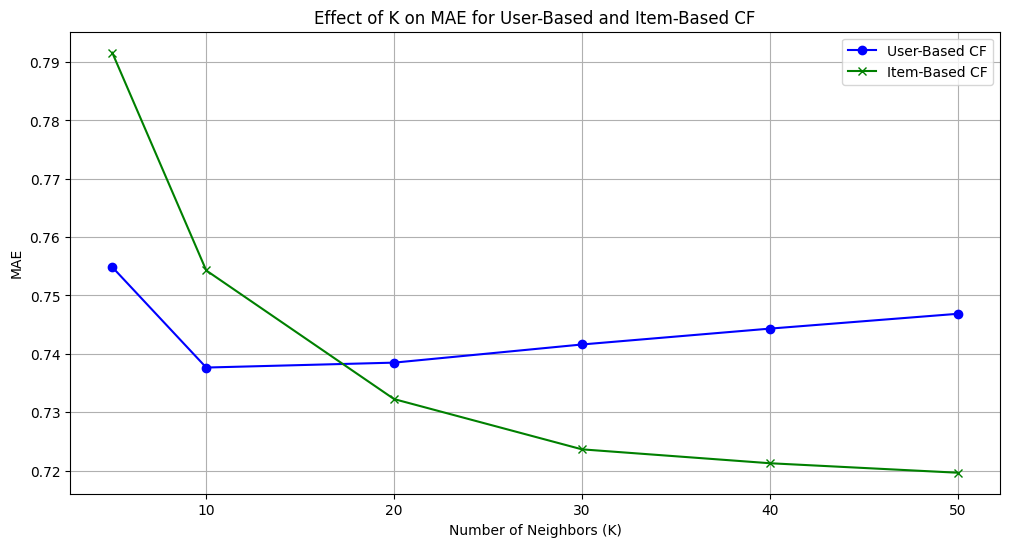

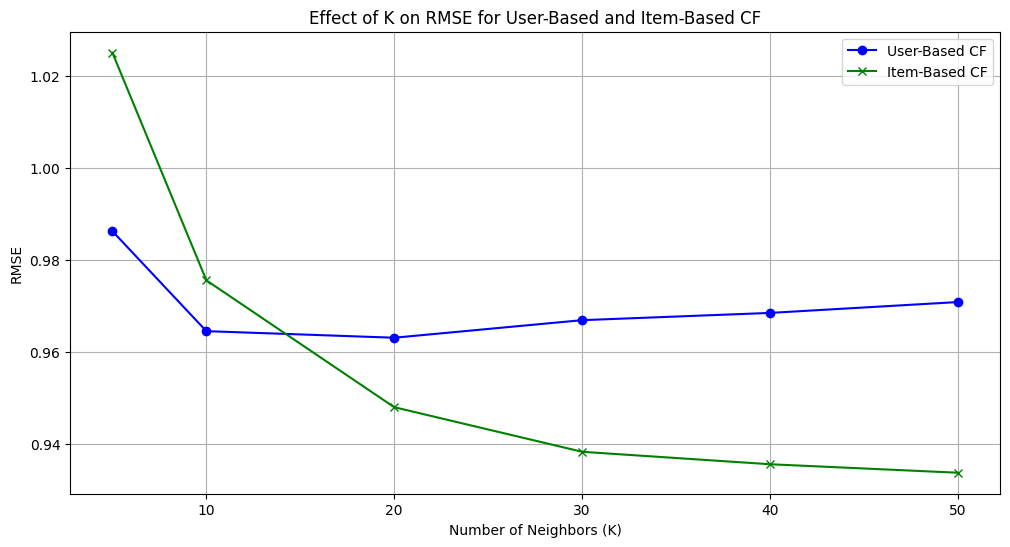

In [ ]:
# Plotting the effect of K on MAE and RMSE for User-Based and Item-Based CF
def plot_k_effect(user_results, item_results, metric):
    plt.figure(figsize=(12, 6))

    plt.plot(user_results['K'], user_results[metric], marker='o', label='User-Based CF', color='blue')

    plt.plot(item_results['K'], item_results[metric], marker='x', label='Item-Based CF', color='green')

    plt.title(f'Effect of K on {metric} for User-Based and Item-Based CF')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results for both MAE and RMSE
plot_k_effect(user_results, item_results, 'MAE')
plot_k_effect(user_results, item_results, 'RMSE')


In [25]:
# Best K for User-Based and Item-Based CF in terms of RMSE
best_k_user = user_results['K'][user_results['RMSE'].index(min(user_results['RMSE']))]
best_k_item = item_results['K'][item_results['RMSE'].index(min(item_results['RMSE']))]

print(f"Optimal K for User-Based CF (minimum RMSE): {best_k_user}")
print(f"Optimal K for Item-Based CF (minimum RMSE): {best_k_item}")


Optimal K for User-Based CF (minimum RMSE): 20
Optimal K for Item-Based CF (minimum RMSE): 50
